In [1]:
import numpy as np
import matplotlib.pyplot as plt
import STOM_higgs_tools
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import chi2

**Section 1** : Generating Data Points

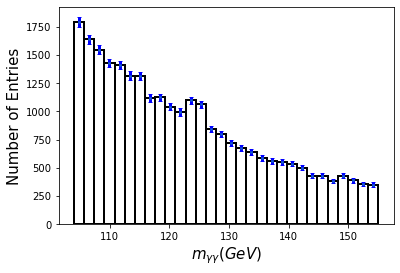

In [42]:
vals = STOM_higgs_tools.generate_data()
nbins=30
mass_range=[104,155]

bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = 30,color='white',edgecolor='black',linewidth=2)
bin_centre=bin_edges+0.5*(bin_edges[1]-bin_edges[0])
plt.xlabel('$m_{\gamma\gamma} (GeV)$',fontsize=15)
plt.ylabel('Number of Entries', fontsize=15)
plt.errorbar(bin_centre[0:30],bin_heights,yerr=np.sqrt(bin_heights),capsize=2,elinewidth=3,fmt='x',ms=2,ecolor='blue')
bin_centre = bin_edges+0.5*(bin_edges[1]-bin_edges[0])
plt.xlabel('$m_{\gamma\gamma} (GeV)$',fontsize=15)
plt.ylabel('Number of Entries', fontsize=15)
plt.savefig('Figure1.jpeg')
plt.show() 

**Section 2a**: Max likelihood method

**Section 2b**: $\chi^2$ Minimisation

Create a range of A and lambda values. For each value of A (`A[i]`), cycle through every lambda value (`lamb[j]`), and calculate the chi-squared values. Check if chi-squared value is less than previous chi-squared values, if so, set these values of A and lambda as the optimum. 

Note that we only use the range `[104,120]` because we need to ignore the higgs boson bump. 

Update: code now searches for minimum after executing all iterations. This speeds up the run-time. 

*Method 1* 2D Search

In [5]:
def twoD_search(vals,L):
    pbar=tqdm(range(L**2))
    L=L#number of A and lambda values to check
    A=np.linspace(4e4,10e4,L) #range of predicted A values
    lamb=np.linspace(27,33,L) #range of predicted lambda values
    chi_grid=np.zeros((L,L))
    mass_range_low=[104,120]
    nbins=9
    for i in range(L):
        for j in range(L):
            chi=STOM_higgs_tools.get_B_chi(vals,mass_range_low,nbins,A[i],lamb[j])
            chi_grid[i,j]=chi
            pbar.update(1)
    min_index = np.unravel_index(np.argmin(chi_grid), chi_grid.shape)
    chi_min=chi_grid[min_index[0],min_index[1]]
    A_opt_b = A[min_index[0]]
    lamb_opt_b = lamb[min_index[1]]
    print(f'lambda = {lamb_opt_b}, A = {A_opt_b}, minimum chi={chi_min}')
    return A_opt_b, lamb_opt_b, chi_min, chi_grid

def twoD_search_full(vals,L):
    L=L#number of A and lambda values to check
    A=np.linspace(4e4,6e4,L) #range of predicted A values
    lamb=np.linspace(27,33,L) #range of predicted lambda values
    chi_grid=np.zeros((L,L))
    mass_range_low=[104,155]
    nbins=30
    for i in range(L):
        for j in range(L):
            chi=STOM_higgs_tools.get_B_chi(vals,mass_range_low,nbins,A[i],lamb[j])
            chi_grid[i,j]=chi
    min_index = np.unravel_index(np.argmin(chi_grid), chi_grid.shape)
    chi_min=chi_grid[min_index[0],min_index[1]]
    A_opt_b = A[min_index[0]]
    lamb_opt_b = lamb[min_index[1]]
    print(f'lambda = {lamb_opt_b}, A = {A_opt_b}, minimum chi={chi_min}')
    return A_opt_b, lamb_opt_b, chi_min

Chi visualisation

In [6]:
A=np.linspace(4e4,10e4,L) #range of predicted A values
lamb=np.linspace(20,40,L)
A_opt,lamb_opt,chi,chi_grid=twoD_search(vals,100)

NameError: name 'L' is not defined

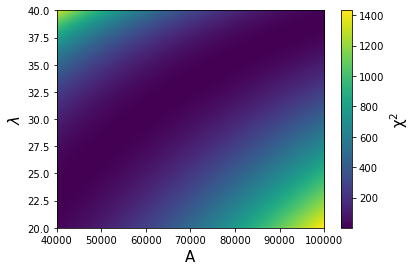

In [253]:
plt.imshow(chi_grid, cmap='viridis', aspect='auto', extent=[np.min(A), np.max(A), np.min(lamb), np.max(lamb)])
cbar=plt.colorbar()
cbar.set_label("χ$^2$",fontsize=15)
plt.xlabel('A',fontsize=15)
plt.ylabel('$\lambda$',fontsize=15)
plt.savefig('colour_map.jpeg',bbox_inches='tight')
plt.show()

*Method 2* Maximum Likelihood

In [7]:
def max_likelihood(vals,mass_range_low,mass_range_high,nbins):
    lamb = (1/(len(vals)))*np.sum(vals) #optimum lambda value
    integral=lamb*(np.exp(-mass_range_low/lamb)-np.exp(-mass_range_high/lamb))
    bin_heights, bin_edges= np.histogram(vals, range = [mass_range_low,mass_range_high], bins = nbins)
    plt.show()
    bin_width=bin_edges[1]-bin_edges[0]
    area = bin_width*np.sum(bin_heights)
    A=area/integral
    return A,lamb

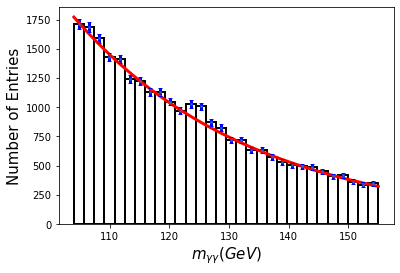

In [254]:
vals=STOM_higgs_tools.generate_data(n_signals=0)
A_opt,lamb_opt=max_likelihood(vals,104,155,30)
vals+=STOM_higgs_tools.generate_signal(400,125,1.5)
x=np.linspace(104,155,int(1e5))
y=STOM_higgs_tools.get_B_expectation(x,A_opt,lamb_opt)
plt.plot(x,y,color='red',linewidth=3)
bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = 30,color='white',edgecolor='black',linewidth=2)
plt.xlabel('$m_{\gamma\gamma} (GeV)$',fontsize=15)
plt.ylabel('Number of Entries', fontsize=15)
plt.errorbar(bin_centre[0:30],bin_heights,yerr=np.sqrt(bin_heights),capsize=2,elinewidth=3,fmt='x',ms=2,ecolor='blue')
bin_centre = bin_edges+0.5*(bin_edges[1]-bin_edges[0])
plt.xlabel('$m_{\gamma\gamma} (GeV)$',fontsize=15)
plt.ylabel('Number of Entries', fontsize=15)
plt.savefig('Plot_plus_background.jpeg',bbox_inches='tight')
plt.show()

**Section 3 and 4a (and 5a):** Goodness of fit

*section 3:* First, we compute the $\chi^2$ value in background-only mass region using the `twoD_search` function. We perform this multiple times to get an average and error. We want to accept this value.

*section 4a:* Then, in each iteration, we also compute the chi^2 value for the *entire* range. We want to reject this value. 

In [22]:
def calculate_p_value(chi_squared,sample_size,parameter_number):
    degrees_of_freedom = sample_size - parameter_number
    p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)
    return p_value

In [280]:
chi_list_b=[] #sect 3 
chi_list_s=[] #sect 4a
chi_list_bs=[] #sect 5a
A_list=[] #optimum A values from each it
lamb_list=[] #optimum lamb values from each it


mass_range_low=104
mass_range_high=155
mass_rage=[mass_range_low,mass_range_high]
nbins=30

signal_mean = 125 
signal_sig = 1.5
signal_amp = 700

simulations=10000
pbar=tqdm(range(simulations))

for i in range(simulations):
    #calculate background fit parameters and chi^2 value (ignoring signal)
    vals=STOM_higgs_tools.generate_data(n_signals=0)
    A, lamb = max_likelihood(vals,mass_range_low,mass_range_high,30)
    chi_b = STOM_higgs_tools.get_B_chi(vals,mass_range,nbins,A,lamb)
    chi_list_b=np.append(chi_list_b,chi_b)
    A_list=np.append(A_list,A)
    lamb_list=np.append(lamb_list,lamb)
    
    #add in signal, and calculate chi^2 value of background fit with signal
    vals+=STOM_higgs_tools.generate_signal(400,125,1.5)
    chi_s = STOM_higgs_tools.get_B_chi(vals,mass_range,nbins,A,lamb)
    chi_list_s=np.append(chi_list_s,chi_s)
    
    #now add the gaussian to the expected fit and re-calculate chi^2 value
    bin_heights, bin_edges= np.histogram(vals, range = mass_range, bins = 30)
    half_bin_width = 0.5*(bin_edges[1] - bin_edges[0])
    bin_centres=bin_edges+half_bin_width
    ys_expected = STOM_higgs_tools.get_SB_expectation(bin_centres, A, lamb, signal_mean, signal_sig, signal_amp)
    chi_bs = 0
    for i in range( len(bin_heights) ):
        chi_nominator = (bin_heights[i] - ys_expected[i])**2
        chi_denominator = ys_expected[i]
        chi_bs += chi_nominator / chi_denominator
    chi_list_bs=np.append(chi_list_bs,chi_bs)
    pbar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

Analysis

29.99944172503802 0.0003033260701179393 56669.26527566059 3.0823759286607397


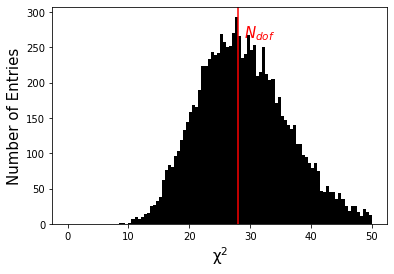

mean chi for background fit (ignoring signal):29.06446658273764+/-0.07643701332204961, p-value 0.4092634685442932
do not reject
mean chi for background fit (with signal):84.92775058557146+/-0.16188536935146017, p-value 1.2049262598790023e-07
reject
mean chi for signal+background fit:29.187546770160598+/-0.07676180840591065, p-value 0.25615215527020974
do not reject


In [281]:
#finding the best output
min_index = np.argmin(chi_list_b)
A_opt_b = A_list[min_index]
lamb_opt_b = lamb_list[min_index]
lamb_mean = np.mean(lamb_list)
lamb_err = np.std(lamb_list)/np.sqrt(len(lamb_list))
A_mean = np.mean(A_list)
A_err = np.std(A_list)/np.sqrt(len(A_list))
print(lamb_mean, lamb_err, A_mean, A_err)

#plotting no signal, background chi^2 values
bin_heights, bin_edges, patches = plt.hist(chi_list_b*(nbins-2), range = [0, 50], bins = 100,color='black')
plt.xlabel('χ$^2$', fontsize=15)
plt.ylabel('Number of Entries', fontsize=15)
plt.axvline(nbins-2, color='red')
plt.annotate('$N_{dof}$', (nbins-1,0.9*np.max(bin_heights)), color='red', fontsize=15)
plt.savefig('10k_sims.jpeg',bbox_inches='tight')
plt.show()
#chi analysis

#background without signal, background only fit
mean_chi_b = np.mean(chi_list_b)*(nbins-2)
err_chi_b = (np.std(chi_list_b)/np.sqrt(len(chi_list_b)))*(nbins-2)

#background with signal, background only fit
mean_chi_s = np.mean(chi_list_s)*(nbins-2)
err_chi_s = (np.std(chi_list_s)/np.sqrt(len(chi_list_s)))*(nbins-2)

#background with signal, background only+gauss fit
mean_chi_bs = np.mean(chi_list_bs)
err_chi_bs = (np.std(chi_list_bs)/np.sqrt(len(chi_list_bs)))

acceptance_range = 0.1
#calculating p_values
nbins=30
n_parameters=2
n_parameters_s=5
p_value_b = calculate_p_value(mean_chi_b, nbins, n_parameters)
print(f'mean chi for background fit (ignoring signal):{mean_chi_b}+/-{err_chi_b}, p-value {p_value_b}')

if p_value_b > acceptance_range:
    print('do not reject')
else:
    print('reject')

p_value_s = calculate_p_value(mean_chi_s, nbins, n_parameters)
print(f'mean chi for background fit (with signal):{mean_chi_s}+/-{err_chi_s}, p-value {p_value_s}')

if p_value_s > acceptance_range:
    print('do not reject')
else:
    print('reject')
              
p_value_bs = calculate_p_value(mean_chi_bs, nbins, n_parameters_s)
print(f'mean chi for signal+background fit:{mean_chi_bs}+/-{err_chi_bs}, p-value {p_value_bs}')

if p_value_bs > acceptance_range:
    print('do not reject')
else:
    print('reject')

In [31]:
p_value= calculate_p_value(44, 30, 5)
print(p_value)

0.010845252970630992


**Section 4a**: 

Chi-squared value for the *entire* range. Now combined with section 3. 


**Section 4b** Now combined with section 3.

**Section 4c:** Finding mean $\chi^2$ value with various signal amplitudes

In [170]:
mass_range_low=104
mass_range_high=155
mass_range=[104,155]
background = STOM_higgs_tools.generate_background(10e5,30)
A, lamb = max_likelihood(vals,mass_range_low,mass_range_high,30)

In [260]:
signal_array=np.arange(0,500,3)
signal_number=len(signal_array)
nbins=30
chi_list=[]
for i in range(signal_number):
    vals=[]
    vals+=background
    signal = STOM_higgs_tools.generate_signal(int(signal_array[i]),125,1.5)
    vals+=signal
    chi_total = STOM_higgs_tools.get_B_chi(vals,mass_range,nbins,A,lamb)*28 #chi value of background fit relative to vals
    chi_list=np.append(chi_list,chi_total)
p_value = calculate_p_value(chi_list, nbins, 2)
for i in range(signal_number):
    if p_value[i]<0.051 and p_value[i]>0.049:
        pos=i
        break

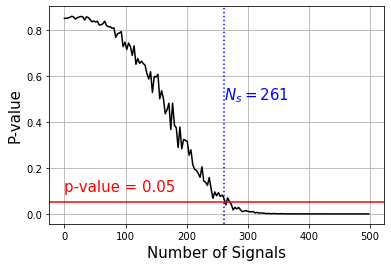

In [257]:
critical_point=signal_array[pos]
plt.plot(signal_array,p_value,color='black')
plt.axhline(y=0.05,color='red')
plt.axvline(x=critical_point, linestyle=':', color='blue')
plt.annotate(f'$N_s=${critical_point}', (critical_point,0.5), fontsize=15, color='blue')
plt.annotate('p-value = 0.05', (0, 0.1),color='red',fontsize=15)
plt.grid()
plt.xlabel('Number of Signals',fontsize=15)
plt.ylabel('P-value',fontsize=15)
plt.savefig('rejection_signals.jpeg',bbox_inches='tight')
plt.show()

In [34]:
signal_array=np.arange(0,500,10)
print(signal_array)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490]


**Section 5a**: Signal Estimation using background parameterisation

Overlaying the signal

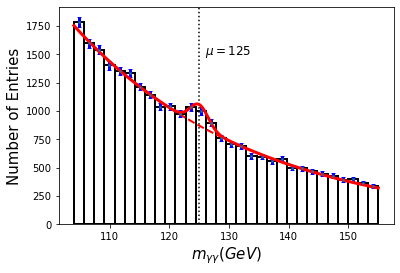

In [265]:
mass_range_low=104
mass_range_high=155
mass_range=[104,155]
vals=[]
background = STOM_higgs_tools.generate_background(10e5,30)
vals+=background
A, lamb = max_likelihood(background,mass_range_low,mass_range_high,30)
vals+=STOM_higgs_tools.generate_signal(400,125,1.5)
bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = 30,color='white',edgecolor='black',linewidth=2)
plt.xlabel('$m_{\gamma\gamma} (GeV)$',fontsize=15)
plt.ylabel('Number of Entries', fontsize=15)
plt.errorbar(bin_centre[0:30],bin_heights,yerr=np.sqrt(bin_heights),capsize=2,elinewidth=3,fmt='x',ms=2,ecolor='blue')
plt.axvline(125,color='Black',ls=':')
plt.annotate('$\mu=125$', (126,1500), fontsize=12)

signal_mean = 125 
signal_sig = 1.5
signal_amp = 700

x=np.linspace(104,155,10000)
y1=STOM_higgs_tools.get_B_expectation(x,A,lamb)
y2=STOM_higgs_tools.get_SB_expectation(x,A,lamb,signal_mean,signal_sig,signal_amp)
plt.plot(x,y1,color='red',linewidth=2,ls='dashed')
plt.plot(x,y2,color='red',linewidth=3)
plt.savefig('background_plus_signal.jpeg',bbox_inches='tight')
plt.show() 


Finding $\chi^2$: now integrated with section 3

**Section 5b:** Unknown Mass

In [8]:
mass_range_low=104
mass_range_high=155
mass_range=[104,155]
vals=STOM_higgs_tools.generate_background(10e5,30)
A, lamb = max_likelihood(vals,mass_range_low,mass_range_high,30)
vals+=STOM_higgs_tools.generate_signal(400,125,1.5)

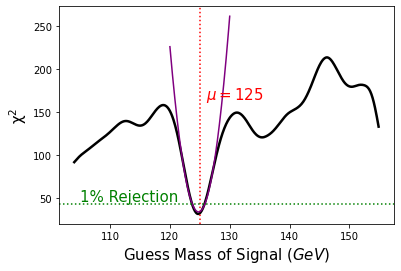

Min is 124.78870871393553+/-0.00954575737792831


In [40]:
bin_heights, bin_edges= np.histogram(vals, range = mass_range, bins = 30)
mass_guess_list = np.arange(104,155,0.1)
mass_guesses=len(mass_guess_list)
half_bin_width = 0.5*(bin_edges[1] - bin_edges[0])
bin_centres=bin_edges+half_bin_width
signal_sig=1.5
signal_amp=700

chi_list_m=[]
for i in range(mass_guesses):
    ys_expected = STOM_higgs_tools.get_SB_expectation(bin_centres, A, lamb, mass_guess_list[i], signal_sig, signal_amp)
    chi = 0
    for j in range( len(bin_heights) ):
        chi_nominator = (bin_heights[j] - ys_expected[j])**2
        chi_denominator = ys_expected[j]
        chi += chi_nominator / chi_denominator
    chi_list_m=np.append(chi_list_m,chi)
plt.plot(mass_guess_list,chi_list_m,color='black',linewidth=2.5)
plt.xlabel('Guess Mass of Signal ($GeV$)',fontsize=15)
plt.ylabel('χ$^2$', fontsize=15)
plt.axvline(125,color='red',ls=':')
plt.annotate('$\mu=125$', (126,165), fontsize=15, color='red')

min_index = np.argmin(chi_list_m)

#fit
def quadratic(x,a,b,c):
    y = a*(x-b)**2 + c
    return y
fit,cov = curve_fit(quadratic, mass_guess_list[min_index-30:min_index+30], chi_list_m[min_index-30:min_index+30])
x=np.linspace(120,130,10000)
y=quadratic(x,*fit)
plt.plot(x,y,color='purple')
plt.axhline(44, color='Green', ls=':')
plt.annotate('1% Rejection',(105,47), fontsize=15, color='green')
plt.savefig('mass_valley.jpeg',bbox_inches='tight')
plt.show()

b=fit[1]
b_err=np.sqrt(cov[1,1])
print(f'Min is {fit[1]}+/-{b_err}')